              precision    recall  f1-score   support

       10344       0.00      0.00      0.00       1.0
      104275       0.00      0.00      0.00       1.0
       10804       0.00      0.00      0.00       1.0
        1085       0.00      0.00      0.00       1.0
       10851       0.00      0.00      0.00       0.0
      112052       0.00      0.00      0.00       0.0
       11383       0.00      0.00      0.00       0.0
      115769       0.00      0.00      0.00       0.0
       12077       0.00      0.00      0.00       1.0
      122370       0.00      0.00      0.00       0.0
       12276       0.00      0.00      0.00       1.0
      123426       0.00      0.00      0.00       0.0
        1240       0.00      0.00      0.00       0.0
      125205       0.00      0.00      0.00       0.0
       12673       0.00      0.00      0.00       0.0
       13287       0.00      0.00      0.00       0.0
       13300       0.00      0.00      0.00       0.0
       13930       0.00    

E:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
E:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
E:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
E:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricW

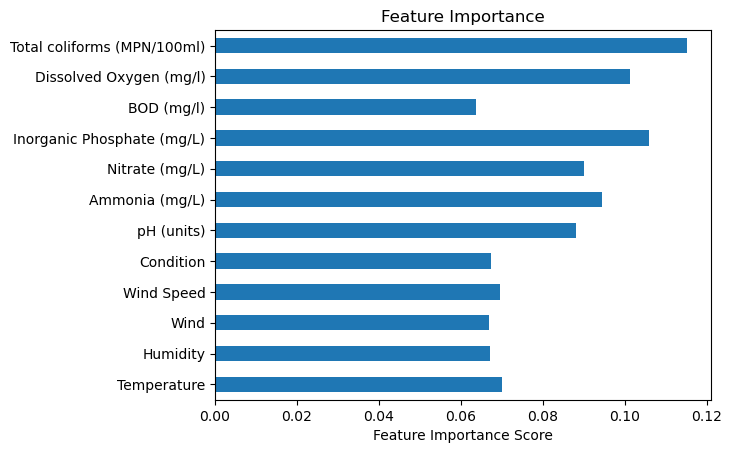

           Monitoring Stations     Month  Year  pH (units)  Ammonia (mg/L)  \
0    Stn. I (Central West Bay)   January  2013        7.68          0.0464   
1    Stn V (Northern West Bay)   January  2013        7.68          0.0824   
2           Stn XV (San Pedro)   January  2013        7.82          0.0678   
3           Stn.XVI (Sta Rosa)   January  2013        7.82          0.0914   
4    Stn. I (Central West Bay)     March  2013        7.82          0.0678   
..                         ...       ...   ...         ...             ...   
435  Stn V (Northern West Bay)  December  2022        7.30          0.0500   
436          Stn XIII (Taytay)  December  2022        8.00          0.0050   
437         Stn XV (San Pedro)  December  2022        7.80          0.0050   
438         Stn.XVI (Sta Rosa)  December  2022        7.60          0.0200   
439       Stn XIX (Muntinlupa)  December  2022        7.70          0.0200   

     Nitrate (mg/L)  Inorganic Phosphate (mg/L)  BOD (mg/l)  \


In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import re

# Load datasets with specified encoding
water_quality_df = pd.read_csv('Overall-dataset-llda(west phyto) assumed_knn_imputed_final2.csv', encoding='latin1')
weather_df = pd.read_csv('Overall-weather-dataset(csv).csv', encoding='iso-8859-1')

# Clean up water_quality_df to remove commas from 'Phytoplankton (cells/ml)'
water_quality_df['Phytoplankton (cells/ml)'] = water_quality_df['Phytoplankton (cells/ml)'].str.replace(',', '')

# List of columns to exclude from transformation
exclude_columns = ['Month', 'Wind', 'Condition']

# Function to remove non-numeric characters from each cell
def remove_non_numeric(value):
    if isinstance(value, str) and value not in exclude_columns:
        # Use regular expression to remove non-numeric characters
        return re.sub(r'[^0-9.]', '', value)
    else:
        return value  # Return unchanged if not a string or in exclude list

# Apply the function to each cell in numeric columns of the dataframe
for column in weather_df.columns:
    if column not in exclude_columns:
        weather_df[column] = weather_df[column].apply(remove_non_numeric)

# Convert the numeric columns to numeric type
numeric_columns = [col for col in weather_df.columns if col not in exclude_columns]
weather_df[numeric_columns] = weather_df[numeric_columns].apply(pd.to_numeric, errors='coerce')

# Define mappings for Wind column
wind_mapping = {
    'N': 1, 'NNE': 2, 'NE': 3, 'ENE': 4,
    'E': 5, 'ESE': 6, 'SE': 7, 'SSE': 8,
    'S': 9, 'SSW': 10, 'SW': 11, 'WSW': 12,
    'W': 13, 'WNW': 14, 'NW': 15, 'NNW': 16,
    'VAR': 17, 'CALM': 18  # Assuming VAR and CALM are special cases
}

# Define mappings for Condition column
condition_mapping = {
    'Fair': 1, 'Mostly Cloudy': 2, 'Partly Cloudy': 3, 'Cloudy': 4,
    'Light Rain': 5, 'Light Rain Shower': 6, 'Rain': 7, 'Heavy Rain': 8,
    'Thunder': 9, 'Light Rain with Thunder': 10, 'T-Storm': 11,
    'Heavy Rain Shower': 12, 'Rain Shower': 13, 'Showers in the Vicinity': 14,
    'Thunder in the Vicinity': 15, 'Mostly Cloudy / Windy': 16,
    'Fair / Windy': 17, 'Partly Cloudy / Windy': 18, 'Rain / Windy': 19,
    'Light Rain Shower / Windy': 20, 'Heavy Rain / Windy': 21
}

# Apply mappings to Wind and Condition columns
weather_df['Wind'] = weather_df['Wind'].map(wind_mapping)
weather_df['Condition'] = weather_df['Condition'].map(condition_mapping)

# Aggregate weather data to monthly averages
weather_monthly_avg = weather_df.groupby(['Year', 'Month']).mean().reset_index()

# Merge datasets on 'Month' and 'Year'
merged_df = pd.merge(water_quality_df, weather_monthly_avg, on=['Month', 'Year'])

# Select relevant features and target
features = ['Temperature', 'Humidity','Wind', 'Wind Speed','Condition', 'pH (units)', 'Ammonia (mg/L)','Nitrate (mg/L)','Inorganic Phosphate (mg/L)','BOD (mg/l)', 'Dissolved Oxygen (mg/l)', 'Total coliforms (MPN/100ml)']
target = 'Phytoplankton (cells/ml)'


merged_df = merged_df.dropna()

# Split data into training and testing sets
X = merged_df[features]
y = merged_df[target]  # Use the classification target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize Random Forest model for classification
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_classifier.fit(X_train, y_train)

# Make predictions
y_pred = rf_classifier.predict(X_test)

# Generate and print classification report
print(classification_report(y_test, y_pred, zero_division='warn'))

# Optionally, plot features importance

feature_importance = pd.Series(rf_classifier.feature_importances_, index=features)
feature_importance.plot(kind='barh')
plt.xlabel('Feature Importance Score')
plt.title('Feature Importance')
plt.show()

accuracy_score(y_test, y_pred)

print(merged_df)

In [3]:
import pickle

In [9]:
with open('model_saved.pkl', 'wb') as file:
    pickle.dump(rf_classifier, file)

In [11]:
import pickle

with open('model_saved.pkl', 'rb') as file:
    model_loaded = pickle.load(file)


In [13]:
model_loaded.predict(X_test)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])